In [124]:
from typing import List, TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END, START

In [125]:
BASE_URL = "http://localhost:1234/v1"
MODEL = "qwen/qwen3-4b-2507" 

LLM = ChatOpenAI(
    model=MODEL,
    base_url=BASE_URL,
    api_key="", # dummy, required by the client
)


@tool
def get_current_time(city: str) -> str:
    """Return the current time in the given city (no timezone accuracy, just demo)."""
    from datetime import datetime
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"Current time in {city}: {now}"


@tool
def execute_code(code: str) -> str:
    """Executes the given Python code."""
    result = exec(code)
    return str(result)


TOOLS = [get_current_time, execute_code]

LLM = LLM.bind_tools(TOOLS)

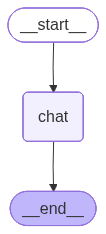

In [126]:
class ChatState(TypedDict):
    messages: List[BaseMessage]


def call_tools(messages: List[BaseMessage]) -> dict:
    for message in messages:
        if isinstance(message, AIMessage) and message.tool_calls:
            for tool_call in message.tool_calls:
                tool_name = tool_call["name"]
                tool_input = tool_call["args"]
                for tool in TOOLS:
                    if tool.name == tool_name:
                        tool_output = tool.invoke(tool_input)
                        messages.append(AIMessage(content=f"Tool '{tool_name}' output: {tool_output}"))
    return messages
    

def chat_node(state: ChatState) -> ChatState:
    messages = state["messages"]
    print(messages)
    response = llm.invoke(messages)
    response = call_tools([response])
    return {"messages": messages + response}


builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.set_entry_point("chat")
builder.add_edge("chat", END)

GRAPH = builder.compile()

GRAPH

In [127]:
state: ChatState = {
    "messages": [HumanMessage(content="What is the square root of 7.671717? Calculate using Python code.")],
}

state = GRAPH.invoke(state)

[HumanMessage(content='What is the square root of 7.671717? Calculate using Python code.', additional_kwargs={}, response_metadata={})]


In [128]:
state['messages']

[HumanMessage(content='What is the square root of 7.671717? Calculate using Python code.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='The square root of 7.671717 is approximately 2.7698. This can be calculated using Python as follows:\n\n```python\nimport math\nresult = math.sqrt(7.671717)\nprint(result)\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 179, 'total_tokens': 236, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen/qwen3-4b-2507', 'system_fingerprint': 'qwen/qwen3-4b-2507', 'id': 'chatcmpl-t5zinhkoakbee7h5c31cct', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--0f0b7130-c80c-42ec-9514-4aa8f7f40758-0', usage_metadata={'input_tokens': 179, 'output_tokens': 57, 'total_tokens': 236, 'input_token_details': {}, 'output_token_details': {}})]